In [10]:
# !pip install lazypredict

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

In [12]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.metrics import  mean_squared_error, roc_curve, roc_auc_score, fbeta_score, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import BayesianRidge, LinearRegression, LassoLarsIC, Lars, LassoLarsCV, Ridge, RANSACRegressor, OrthogonalMatchingPursuitCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import LinearSVR
from lazypredict.Supervised import LazyRegressor

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [13]:
df = pd.read_csv('/content/MSN.csv')

## NOTE
Ticker: Mã cổ phiếu.  
Date/Time: Ngày và thời gian giao dịch.  
Open: Giá mở.  
High: Giá cao nhất.  
Low: Giá thấp nhất.  
Close: Giá đóng.  
Volume: Khối lượng giao dịch.   
Open Interest: Số lượng hợp đồng mở.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [15]:
df['Close1'] = df['Close'].shift(-1)
df['Close2'] = df['Close1'].shift(-1)
df['Close3'] = df['Close2'].shift(-1)
df['Close4'] = df['Close3'].shift(-1)
df = df.dropna(subset=['Close4'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135350 entries, 0 to 135349
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135350 non-null  object 
 1   Date/Time      135350 non-null  object 
 2   Open           135350 non-null  float64
 3   High           135350 non-null  float64
 4   Low            135350 non-null  float64
 5   Close          135350 non-null  float64
 6   Volume         135350 non-null  int64  
 7   Open Interest  135350 non-null  int64  
 8   Close1         135350 non-null  float64
 9   Close2         135350 non-null  float64
 10  Close3         135350 non-null  float64
 11  Close4         135350 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 13.4+ MB


## chia train test từ data test và thử trên tất cả model bằng lazypredict

In [17]:
# chỉ lấy 10k row để test do giới hạn Ram
df_test = df.iloc[:10000]

In [18]:
df_test.head(5)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Close1,Close2,Close3,Close4
0,MSN,12/25/2017 9:15,73.10,73.10,73.10,73.10,4210,0,73.00,73.50,73.10,73.00
1,MSN,12/25/2017 9:16,73.00,73.00,73.00,73.00,5000,0,73.50,73.10,73.00,73.10
2,MSN,12/25/2017 9:18,73.50,73.50,73.50,73.50,210,0,73.10,73.00,73.10,73.10
3,MSN,12/25/2017 9:20,73.20,73.50,73.10,73.10,2050,0,73.00,73.10,73.10,73.30
4,MSN,12/25/2017 9:21,73.00,73.00,73.00,73.00,1380,0,73.10,73.10,73.30,73.50


In [19]:
df_test['Open Interest'].value_counts()

Open Interest
0    10000
Name: count, dtype: int64

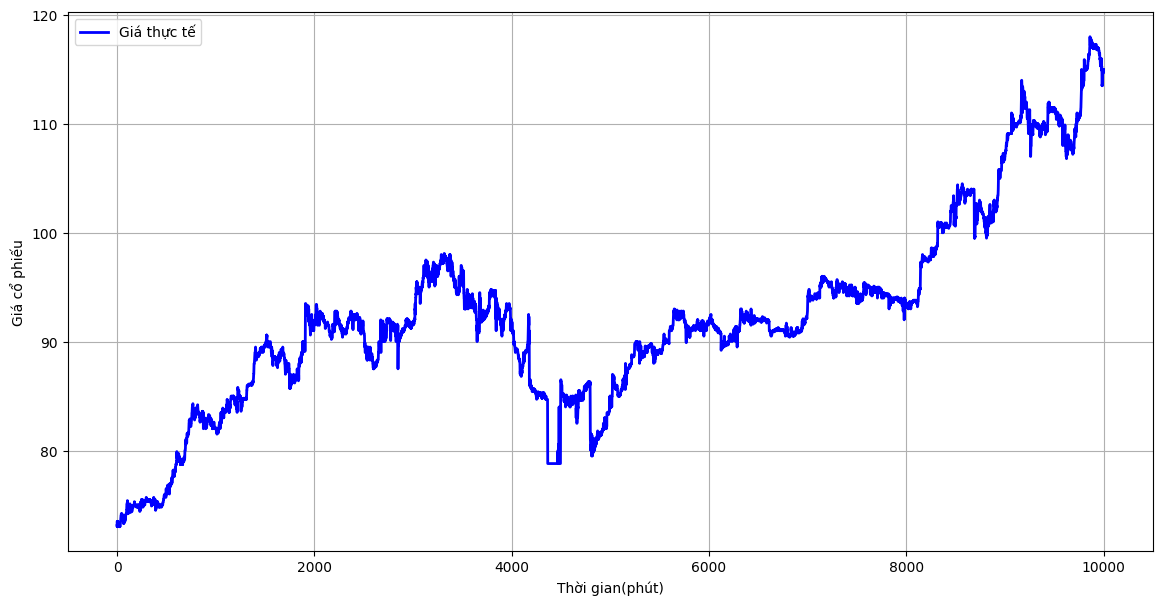

In [20]:
results = pd.DataFrame({
    'Date': df_test.index,
    'Actual': df_test['Close']
})

results = results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
plt.xlabel('Thời gian(phút)')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
df_test=df_test.drop(['Ticker', 'Date/Time'],axis=1)

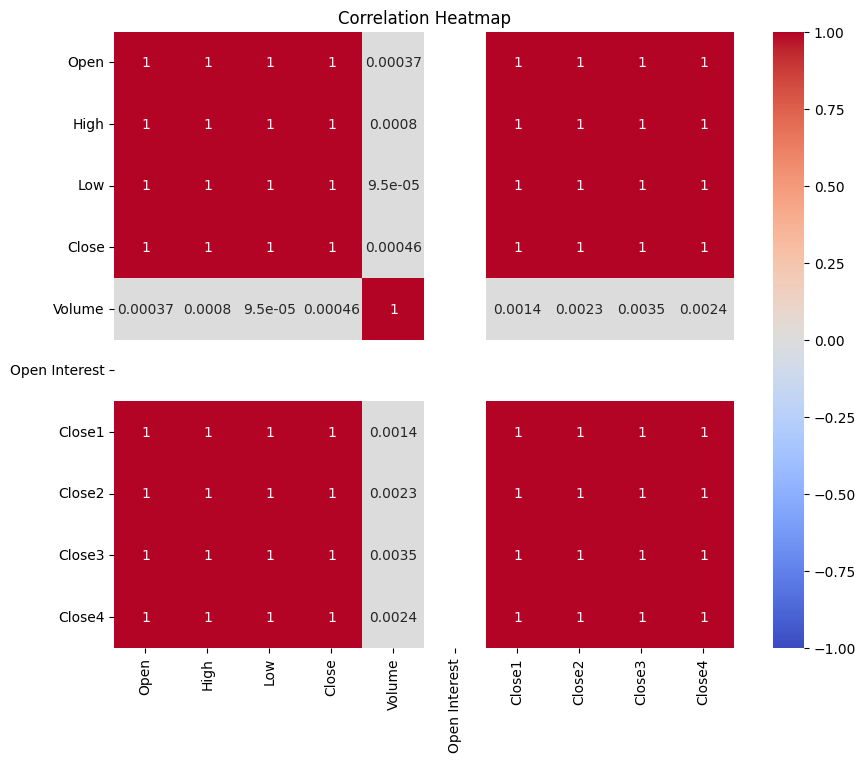

In [22]:
correlation_matrix = df_test.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [23]:
df_test.dropna()

X=df_test.drop(['Volume','Open Interest'],axis=1)
Y=df_test['Close4']

In [24]:
def train_test_split(X, Y, train_size=0.8):
  x_train = X[:int(train_size*len(X))]
  y_train = Y[:int(train_size*len(X))]
  x_test = X[int(train_size*len(X)):]
  y_test = Y[int(train_size*len(X)):]
  return x_train, x_test, y_train, y_test

In [25]:
X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy = train_test_split(X, Y)

In [26]:
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=mean_squared_error)

models, predictions = lazy_reg.fit(X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy)

models

100%|██████████| 42/42 [00:51<00:00,  1.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 88.807575


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_squared_error
Model,,,,,
BayesianRidge,1.00,1.00,0.00,0.04,0.00
OrthogonalMatchingPursuitCV,1.00,1.00,0.00,0.02,0.00
OrthogonalMatchingPursuit,1.00,1.00,0.00,0.01,0.00
RANSACRegressor,1.00,1.00,0.00,0.03,0.00
LassoLarsCV,1.00,1.00,0.00,0.04,0.00
LarsCV,1.00,1.00,0.00,0.02,0.00
LinearRegression,1.00,1.00,0.00,0.03,0.00
LassoLarsIC,1.00,1.00,0.00,0.04,0.00
Lars,1.00,1.00,0.00,0.04,0.00


# chọn ra top n model tốt nhất theo số liệu RMSE


In [27]:
sorted_models = models.sort_values(by='RMSE')

top_10_models = sorted_models.head(10)

top_10_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_squared_error
Model,,,,,
LarsCV,1.00,1.00,0.00,0.02,0.00
LassoLarsIC,1.00,1.00,0.00,0.04,0.00
LassoLarsCV,1.00,1.00,0.00,0.04,0.00
Lars,1.00,1.00,0.00,0.04,0.00
OrthogonalMatchingPursuit,1.00,1.00,0.00,0.01,0.00
OrthogonalMatchingPursuitCV,1.00,1.00,0.00,0.02,0.00
TransformedTargetRegressor,1.00,1.00,0.00,0.03,0.00
LinearRegression,1.00,1.00,0.00,0.03,0.00
RANSACRegressor,1.00,1.00,0.00,0.03,0.00


## chia train test từ data gốc và train trên các model tốt nhất và các thuật toán scaler

In [28]:
X=df.drop(['Ticker', 'Date/Time', 'Close', 'Volume','Open Interest'],axis=1)
Y=df['Close4']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [52]:
regressors = {
    'BayesianRidge': (BayesianRidge(), {'regressor__n_iter': [300, 500, 1000]}),
    'TransformedTargetRegressor': (TransformedTargetRegressor(regressor=LinearRegression()), {}),
    'LinearRegression': (LinearRegression(), {}),
    'OrthogonalMatchingPursuitCV': (OrthogonalMatchingPursuitCV(), {}),
    'RANSACRegressor': (RANSACRegressor(), {}),
    'LassoLarsIC': (LassoLarsIC(), {'regressor__criterion': ['aic', 'bic']}),
    'Lars': (Lars(), {'regressor__n_nonzero_coefs': [5, 10, 20]}),
    'LassoLarsCV': (LassoLarsCV(), {'regressor__cv': [5]}),
    'LinearSVR': (LinearSVR(), {'regressor__C': [0.1, 1, 10], 'regressor__epsilon': [0.1, 0.2]}),
    'Ridge': (Ridge(), {'regressor__alpha': [0.1, 1, 10]})
}

scalers={'Standard Scaler' :StandardScaler(),
         'Min Max Scaler':MinMaxScaler(),
         'Roobust Scaler': RobustScaler(),
         'No Scaler': None
        }

tscv = TimeSeriesSplit(n_splits=5)
rmse_scorer = make_scorer(lambda y_true, y_pred: -mean_squared_error(y_true, y_pred, squared=False))  # RMSE scorer

# chọn ra best model và scaler

In [53]:
best_rmse = float('inf')
best_regressor = None
best_scaler = None
best_params = None

for reg_name, (regressor, param_grid) in regressors.items():
    for scaler_name, scaler in scalers.items():
        pipeline_steps = []
        if scaler:
            pipeline_steps.append(('scaler', scaler))
        pipeline_steps.append(('regressor', regressor))
        pipeline = Pipeline(steps=pipeline_steps)

        grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        mean_rmse = -grid_search.best_score_
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_regressor = reg_name
            best_scaler = scaler_name
            best_params = grid_search.best_params_

print("Best model:", best_regressor)
print("Best params:", best_params)
print("Best scaler:", best_scaler)
print("Best mean RMSE:", best_rmse)

Best model: OrthogonalMatchingPursuitCV
Best params: {}
Best scaler: Standard Scaler
Best mean RMSE: 2.041447089953575e-14


In [54]:
best_model = regressors[best_regressor][0]
best_scaler_ = scalers[best_scaler]
best_params_ = best_params
best_params_cleaned = {}

for key, value in best_params_.items():
    new_key = key.split('__')[-1]
    best_params_cleaned[new_key] = value

best_pipeline = Pipeline([
    ('scaler', best_scaler_),
    ('classifier', best_model.set_params(**best_params_cleaned))
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', OrthogonalMatchingPursuitCV())])

In [63]:
y_pred = best_pipeline.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print("Test MAE is: {:.4f}".format(test_mae))
print("Test MSE is: {:.4f}".format(test_mse))
print("Test RMSE is: {:.4f}".format(test_rmse))
print("Test R^2 Score is: {:.4f}".format(test_r2))

Test MAE is: 0.0000
Test MSE is: 0.0000
Test RMSE is: 0.0000
Test R^2 Score is: 1.0000


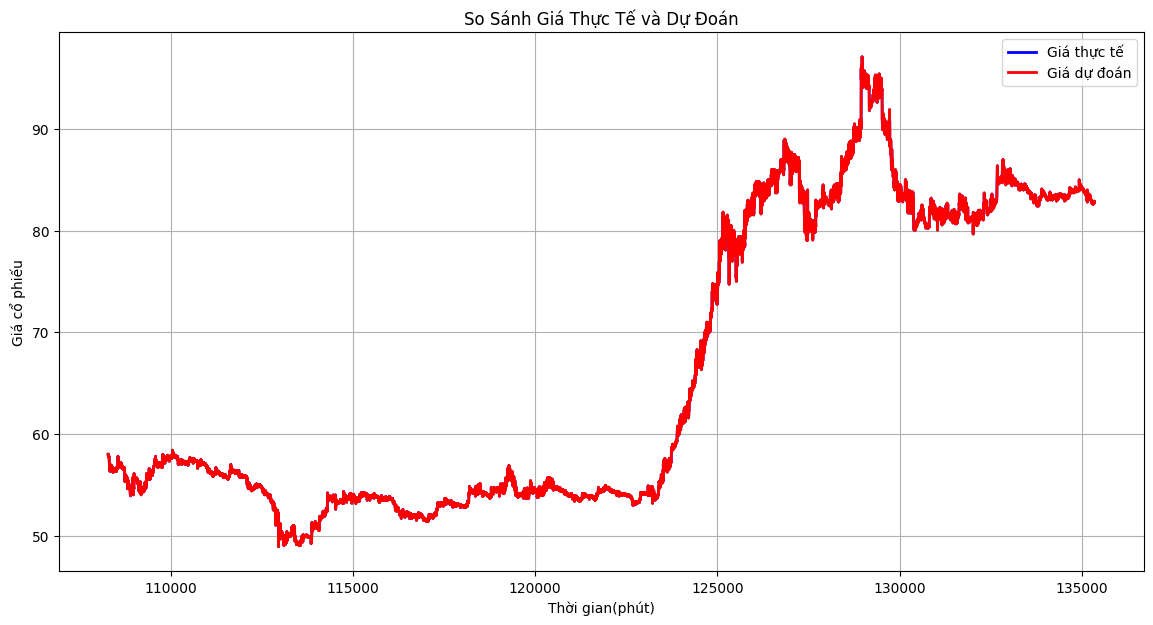

In [64]:
results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': y_pred
})

results = results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
plt.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
plt.xlabel('Thời gian(phút)')
plt.ylabel('Giá cổ phiếu')
plt.title('So Sánh Giá Thực Tế và Dự Đoán')
plt.legend()
plt.grid(True)
plt.show()

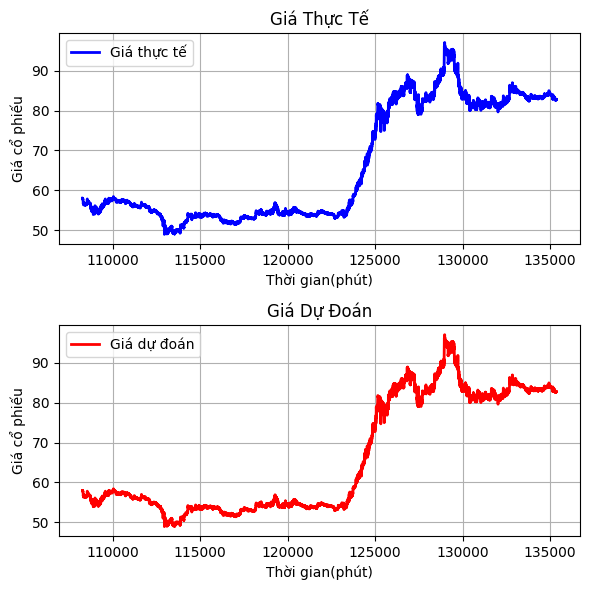

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax1.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
ax1.set_xlabel('Thời gian(phút)')
ax1.set_ylabel('Giá cổ phiếu')
ax1.set_title('Giá Thực Tế')
ax1.legend()
ax1.grid(True)

ax2.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
ax2.set_xlabel('Thời gian(phút)')
ax2.set_ylabel('Giá cổ phiếu')
ax2.set_title('Giá Dự Đoán')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

In [36]:
dump(best_pipeline, 'stock_price_prediction.joblib')

['stock_price_prediction.joblib']

In [37]:
# loaded_pipeline = load('stock_price_prediction.joblib')

In [65]:
single_test = X_test.iloc[4].to_numpy().reshape(1, -1)
y_pred = best_pipeline.predict(single_test)
print(f'giá thực tế',y_test.iloc[4])
print(f'giá dự đoán',y_pred)

giá thực tế 58.0
giá dự đoán [58.]


# sử dụng LSTM

In [41]:
X=df.drop(['Ticker', 'Date/Time', 'Close', 'Volume','Open Interest'],axis=1)
Y=df['Close4']

In [42]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, Y)

In [43]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [44]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [45]:
lstm_model.fit(X_train, y_train, epochs=16, batch_size=128, verbose=2)

Epoch 1/16
846/846 - 8s - loss: 2786.7590 - 8s/epoch - 10ms/step
Epoch 2/16
846/846 - 4s - loss: 627.1316 - 4s/epoch - 5ms/step
Epoch 3/16
846/846 - 4s - loss: 247.5302 - 4s/epoch - 5ms/step
Epoch 4/16
846/846 - 4s - loss: 87.0644 - 4s/epoch - 4ms/step
Epoch 5/16
846/846 - 4s - loss: 17.2261 - 4s/epoch - 5ms/step
Epoch 6/16
846/846 - 5s - loss: 8.0078 - 5s/epoch - 6ms/step
Epoch 7/16
846/846 - 4s - loss: 4.3677 - 4s/epoch - 4ms/step
Epoch 8/16
846/846 - 4s - loss: 2.2282 - 4s/epoch - 4ms/step
Epoch 9/16
846/846 - 5s - loss: 1.0568 - 5s/epoch - 6ms/step
Epoch 10/16
846/846 - 5s - loss: 0.4671 - 5s/epoch - 6ms/step
Epoch 11/16
846/846 - 4s - loss: 0.1990 - 4s/epoch - 4ms/step
Epoch 12/16
846/846 - 4s - loss: 0.0958 - 4s/epoch - 5ms/step
Epoch 13/16
846/846 - 8s - loss: 0.0537 - 8s/epoch - 9ms/step
Epoch 14/16
846/846 - 6s - loss: 0.0302 - 6s/epoch - 7ms/step
Epoch 15/16
846/846 - 8s - loss: 0.0208 - 8s/epoch - 10ms/step
Epoch 16/16
846/846 - 4s - loss: 0.0164 - 4s/epoch - 5ms/step


In [46]:
y_pred_LSTM = lstm_model.predict(X_test)

846/846 [==============================] - 4s 4ms/step


In [47]:
test_mae = mean_absolute_error(y_test, y_pred_LSTM)
test_mse = mean_squared_error(y_test, y_pred_LSTM)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_LSTM)

print("Test MAE is: {:.4f}".format(test_mae))
print("Test MSE is: {:.4f}".format(test_mse))
print("Test RMSE is: {:.4f}".format(test_rmse))
print("Test R^2 Score is: {:.4f}".format(test_r2))

Test MAE is: 0.04
Test MSE is: 0.00
Test RMSE is: 0.06
Test R^2 Score is: 1.00


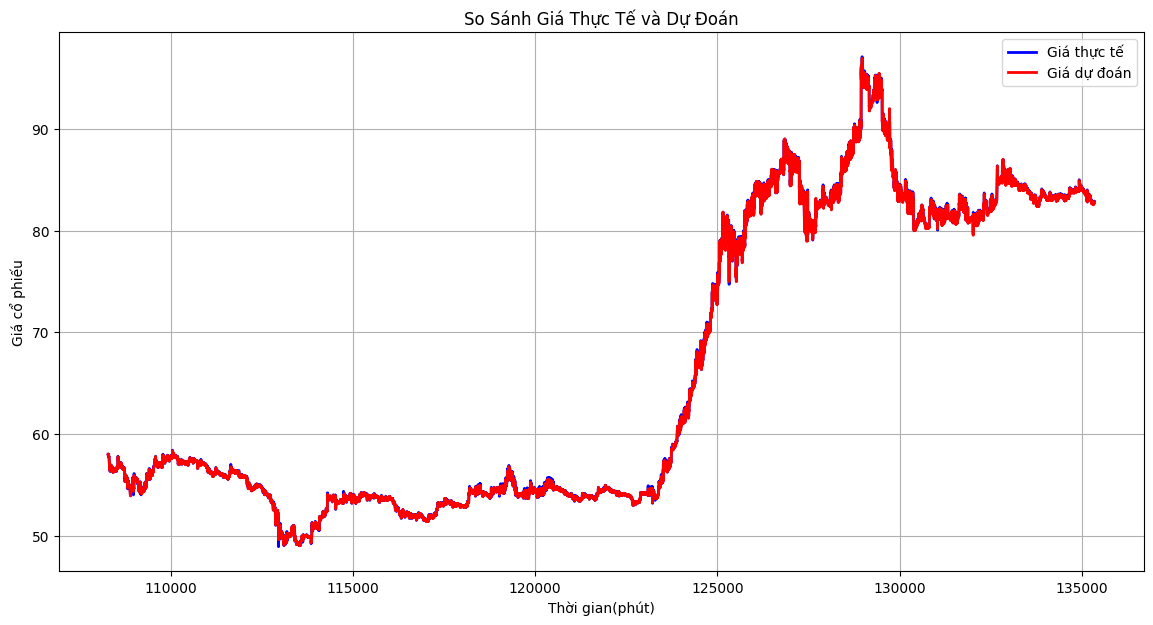

In [48]:
results = pd.DataFrame({
    'Date': X_test_lstm.index,
    'Actual': y_test_lstm,
    'Predicted': y_pred_LSTM.flatten()

})

results = results.sort_values(by='Date')

plt.figure(figsize=(14, 7))
plt.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
plt.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
plt.xlabel('Thời gian(phút)')
plt.ylabel('Giá cổ phiếu')
plt.title('So Sánh Giá Thực Tế và Dự Đoán')
plt.legend()
plt.grid(True)
plt.show()

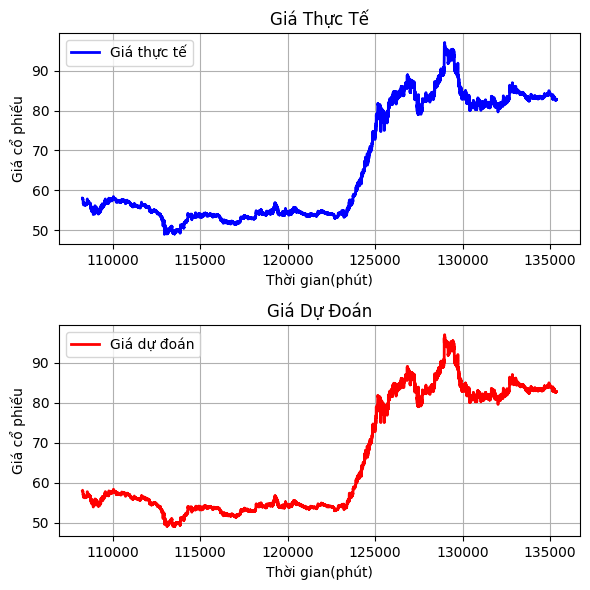

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax1.plot(results['Date'], results['Actual'], label='Giá thực tế', color='blue', linewidth=2)
ax1.set_xlabel('Thời gian(phút)')
ax1.set_ylabel('Giá cổ phiếu')
ax1.set_title('Giá Thực Tế')
ax1.legend()
ax1.grid(True)

ax2.plot(results['Date'], results['Predicted'], label='Giá dự đoán', color='red', linewidth=2)
ax2.set_xlabel('Thời gian(phút)')
ax2.set_ylabel('Giá cổ phiếu')
ax2.set_title('Giá Dự Đoán')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plt.show()

In [66]:
single_test = X_test.iloc[4].to_numpy().reshape(1, -1)
y_pred_LSTM = lstm_model.predict(single_test)
print(f'giá thực tế',y_test.iloc[4])
print(f'giá dự đoán',y_pred_LSTM)

1/1 [==============================] - 1s 604ms/step
giá thực tế 58.0
giá dự đoán [[57.958305]]


In [50]:
lstm_model.save("LSTM_model.h5")